<a href="https://colab.research.google.com/github/MWFK/Catboost-for-dummies/blob/main/xgb_prod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:56:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


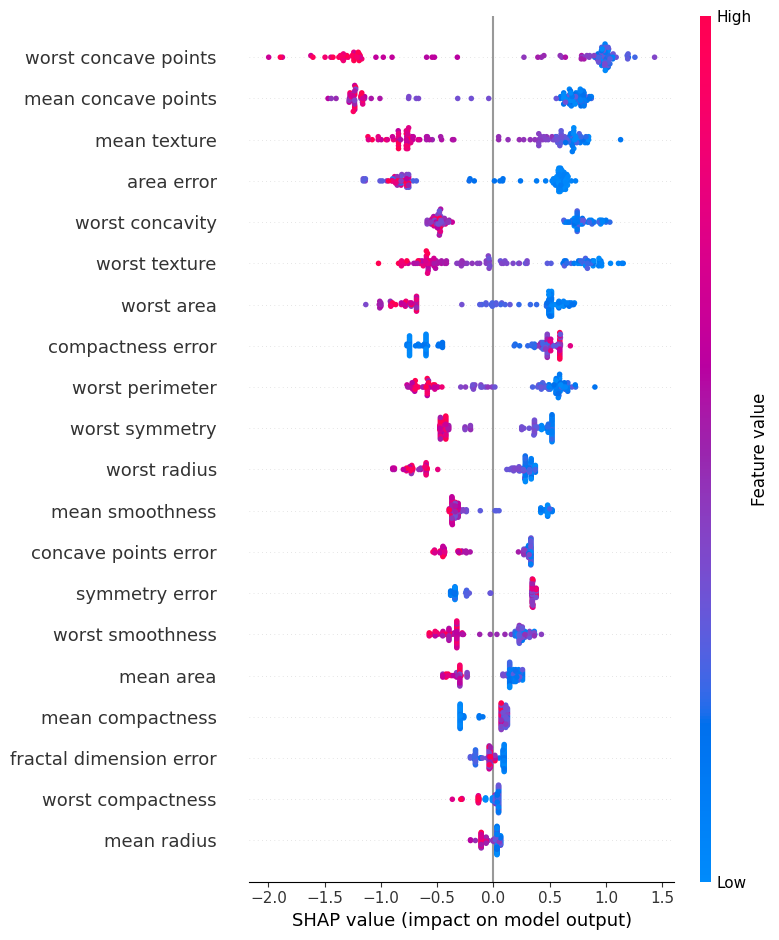

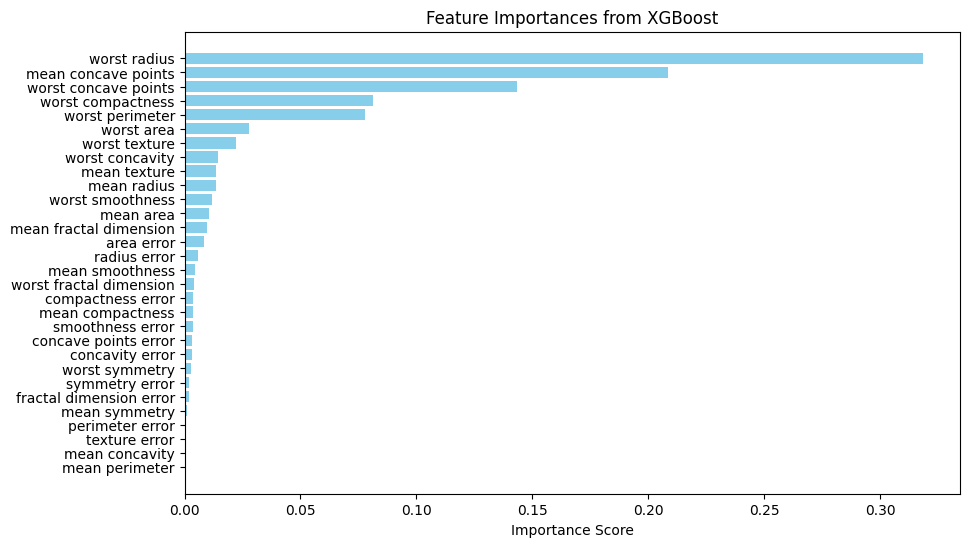

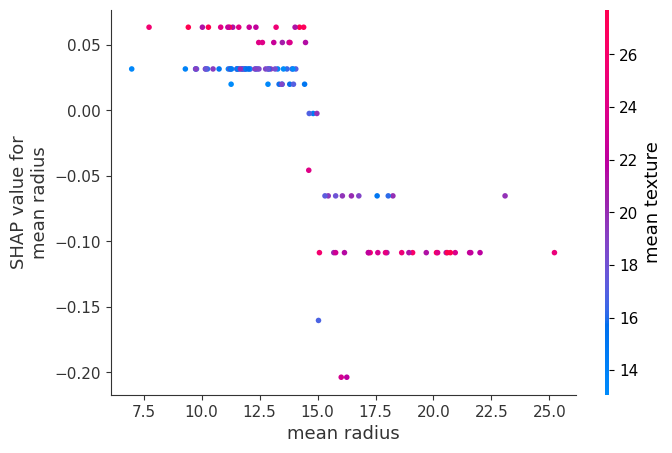

In [ ]:
import logging
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import shap
import joblib

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class DataHandler:
    """
    Handles loading and splitting of data.
    """
    def __init__(self):
        self.data = load_breast_cancer()

    def load_and_split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training and testing sets.

        Args:
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Seed used by the random number generator.

        Returns:
            X_train, X_test, y_train, y_test (tuple): Split data.
        """
        X = self.data.data
        y = self.data.target
        try:
            return train_test_split(X, y, test_size=test_size, random_state=random_state)
        except Exception as e:
            logging.error(f"Error in data splitting: {e}")
            raise

class HyperparameterTuner:
    """
    Handles hyperparameter tuning using RandomizedSearchCV.
    """
    def __init__(self, model):
        self.model = model

    def perform_hyperparameter_tuning(self, X_train, y_train, n_iter=100):
        """
        Performs hyperparameter tuning.

        Args:
            X_train (numpy.ndarray): Training data features.
            y_train (numpy.ndarray): Training data labels.
            n_iter (int): Number of parameter settings sampled.

        Returns:
            best_params (dict): Best hyperparameters found.
        """
        param_dist = {
            'max_depth': randint(3, 10),
            'learning_rate': uniform(0.01, 0.3),
            'n_estimators': randint(50, 200),
            'subsample': uniform(0.7, 0.3),
            'colsample_bytree': uniform(0.7, 0.3),
            'gamma': uniform(0, 0.5),
            'min_child_weight': randint(1, 10),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
            'scale_pos_weight': uniform(1, 10),
        }

        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        random_search = RandomizedSearchCV(estimator=self.model, param_distributions=param_dist,
                                           n_iter=n_iter, cv=kf, scoring='accuracy', verbose=1,
                                           random_state=42, n_jobs=-1)

        try:
            random_search.fit(X_train, y_train)
            logging.info("Best hyperparameters:", random_search.best_params_)
            return random_search.best_params_
        except Exception as e:
            logging.error(f"Error during hyperparameter tuning: {e}")
            raise

class ModelTrainer:
    """
    Handles training the model and saving it.
    """
    def __init__(self, best_params):
        self.best_params = best_params

    def train_model(self, X_train, y_train):
        """
        Trains the model with the best hyperparameters and saves it.

        Args:
            X_train (numpy.ndarray): Training data features.
            y_train (numpy.ndarray): Training data labels.

        Returns:
            best_model (XGBClassifier): Trained model.
        """
        try:
            best_model = xgb.XGBClassifier(**self.best_params, use_label_encoder=False)
            best_model.fit(X_train, y_train)
            joblib.dump(best_model, 'best_xgb_model.joblib')
            return best_model
        except Exception as e:
            logging.error(f"Error during model training: {e}")
            raise

class ModelEvaluator:
    """
    Handles evaluating the model's performance.
    """
    @staticmethod
    def evaluate_model(model, X_test, y_test):
        """
        Evaluates the model on the test set and prints metrics.

        Args:
            model (XGBClassifier): Trained model.
            X_test (numpy.ndarray): Testing data features.
            y_test (numpy.ndarray): Testing data labels.
        """
        try:
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            accuracy = accuracy_score(y_test, y_pred)
            logging.info(f"Test accuracy: {accuracy:.2f}")
            logging.info(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}")
            logging.info(classification_report(y_test, y_pred))
        except Exception as e:
            logging.error(f"Error during model evaluation: {e}")
            raise

class ModelInterpreter:
    """
    Handles model interpretation and visualization, including SHAP plots and feature importances.
    """
    def __init__(self, model, X_test, feature_names):
        """
        Initializes the interpreter with the trained model, test data, and feature names.

        Args:
            model (XGBClassifier): Trained XGBoost model.
            X_test (numpy.ndarray): Testing data features.
            feature_names (list): Names of the features used in the model.
        """
        self.model = model
        self.X_test = X_test
        self.feature_names = feature_names
        try:
            self.explainer = shap.Explainer(self.model)  # Create SHAP explainer once to reuse
        except Exception as e:
            logging.error(f"Error initializing SHAP explainer: {e}")
            raise

    def plot_shap_summary(self):
        """
        Plots SHAP summary plot for global feature importance interpretation.
        """
        try:
            shap_values = self.explainer(self.X_test)  # Get SHAP values

            # Convert SHAP values to array-like format for plotting if necessary
            shap_values_array = shap_values.values  # Use shap_values.data if it's attribute-like

            # SHAP summary plot
            shap.summary_plot(shap_values_array, self.X_test, feature_names=self.feature_names)
        except Exception as e:
            logging.error(f"Error in plotting SHAP summary: {e}")
            raise

    def plot_feature_importance(self):
        """
        Plots the feature importance based on the trained model's internal scoring.
        """
        try:
            feature_importances = self.model.feature_importances_

            # Create DataFrame for feature importances
            feature_scores_df = pd.DataFrame({
                'Feature': self.feature_names,
                'Importance': feature_importances
            }).sort_values(by='Importance', ascending=False)

            # Print feature importance
            logging.info(feature_scores_df)

            # Plot using matplotlib
            plt.figure(figsize=(10, 6))
            plt.barh(feature_scores_df['Feature'], feature_scores_df['Importance'], color='skyblue')
            plt.xlabel('Importance Score')
            plt.title('Feature Importances from XGBoost')
            plt.gca().invert_yaxis()  # Invert y-axis
            plt.show()
        except Exception as e:
            logging.error(f"Error in plotting feature importance: {e}")
            raise

    def plot_shap_dependence(self, feature):
        """
        Plots the SHAP dependence plot for a specific feature to understand interactions.

        Args:
            feature (str): The name of the feature for which to create the dependence plot.
        """
        try:
            shap_values = self.explainer(self.X_test)

            # Convert to array-like format if necessary
            shap_values_array = shap_values.values

            # SHAP dependence plot: Automatically selects color feature or uses provided
            shap.dependence_plot(feature, shap_values_array, self.X_test, feature_names=self.feature_names)
        except Exception as e:
            logging.error(f"Error in plotting SHAP dependence plot: {e}")
            raise

    def plot_force_explanation(self, instance_index):
        """
        Plots a SHAP force plot for a specific prediction instance to understand local explanations.

        Args:
            instance_index (int): The index of the instance in the test set for which to create the force plot.
        """
        try:
            shap_values = self.explainer(self.X_test)

            # SHAP force plot for a single instance
            shap.force_plot(self.explainer.expected_value, shap_values.values[instance_index],
                            self.X_test[instance_index], feature_names=self.feature_names)
        except Exception as e:
            logging.error(f"Error in plotting SHAP force plot: {e}")
            raise

def main():
    """
    Main function to execute the workflow.
    """
    try:
        # Data Handling
        data_handler = DataHandler()
        X_train, X_test, y_train, y_test = data_handler.load_and_split_data()

        # Initialize and tune the model
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        tuner = HyperparameterTuner(model)
        best_params = tuner.perform_hyperparameter_tuning(X_train, y_train)

        # Train the model
        trainer = ModelTrainer(best_params)
        best_model = trainer.train_model(X_train, y_train)

        # Evaluate the model
        evaluator = ModelEvaluator()
        evaluator.evaluate_model(best_model, X_test, y_test)

        # Interpret the model
        interpreter = ModelInterpreter(best_model, X_test, data_handler.data.feature_names)

        # SHAP summary plot (global feature importance)
        interpreter.plot_shap_summary()
        # Plot feature importance based on XGBoost's internal importance metric
        interpreter.plot_feature_importance()
        # Plot SHAP dependence plot for a specific feature (e.g., 'mean radius')
        interpreter.plot_shap_dependence('mean radius')
        # Plot SHAP force plot for a specific prediction instance (e.g., instance at index 0)
        interpreter.plot_force_explanation(instance_index=0)

    except Exception as e:
        logging.error(f"An error occurred: {e}")

if __name__ == "__main__":
    main()